# Edge Detection and Image Segmentation

Before we start; some clarifications:
* Histogram equalisation - same pixels land on same value (this is why it works best when applied to images with much higher color depth than palette size, like continuous data or 16-bit gray-scale images e.g. xrays). See example [here](https://en.wikipedia.org/wiki/Histogram_equalization).
* In theory, if the histogram equalization function is known, then the original histogram can be recovered.

Moving on; today we will cover the following topics in OpenCV

* Laplacian edge detection
* Sobel edge detection
* Canny edge detection
* Contour identification
* Bounding box creation

We'll also touch upon a few other segmentation techniques:
* KMeans
* Masking

Edge detection is needed to detect objects in a picture. An edge is mathematically defined as a distinct change in pixel value. 

![Pre derivative](images/prederivative.png)
Edges can be identified by derivatives

The first derivative (or slope) will have the highest value at the point of the edge. Sobel Filters use this concept to identify edges.
![First derivative](images/first_derivative.png)

The second derivative will be 0 at the edge. Laplacian uses the second derivative to identify the edge.
![Second Derivative](images/second_derivative.png)



In [1]:
#import libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

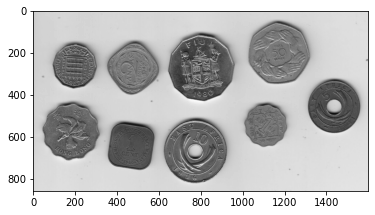

In [6]:
#read in image and save out rgb and grayscale versions
image_bgr = cv2.imread("images/coin_collection.jpeg")
# image_bgr = cv2.imread("images/checkerboard.jpeg")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
image = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

plt.imshow(image,'gray')

### Sobel 

Sobel filters involve a matrix convolution that gives the approximate derivative and therefore gradient. 
![Sobel Kernel](images/sobel_kernels.png)
These filters are applied both horizontally and vertically.

We use a 64 bit float representation (as opposed to the 8-bit representation used for images before) because edge definitions can be +ve (black-white) or -ve (white-black). 8-bit representation is therefore no longer sufficient.

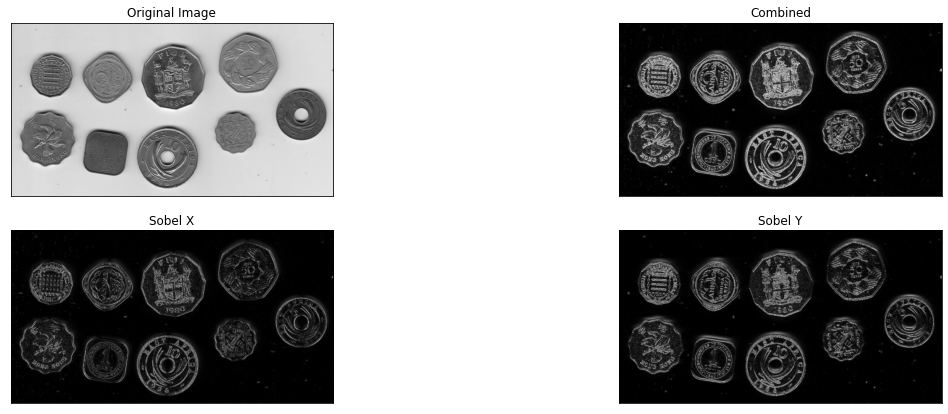

In [7]:
sobelX = cv2.Sobel(image, cv2.CV_64F, 1, 0) #vertical edges
sobelY = cv2.Sobel(image, cv2.CV_64F, 0, 1) #horizontal edges
sobelX = np.uint8(np.absolute(sobelX))
sobelY = np.uint8(np.absolute(sobelY))
sobelCombined = cv2.bitwise_or(sobelX, sobelY)
titles = ['Original Image', 'Combined',
            'Sobel X', 'Sobel Y']
images = [image, sobelCombined, sobelX, sobelY]
plt.figure(figsize=[20,7])
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

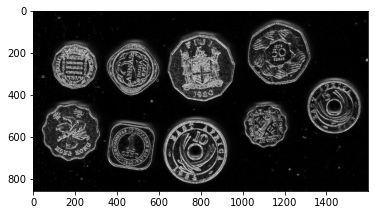

In [8]:
plt.imshow(sobelCombined,'gray')

### Laplacian
The Laplacian involves calculating the double derivative of pixel values. In an ideal scenario the edge the first derivative is highest and the second derivative is 0. This is the fundamental idea behind Laplacian edge detection.

![Laplace Kernel](images/laplacian_kernel.png)


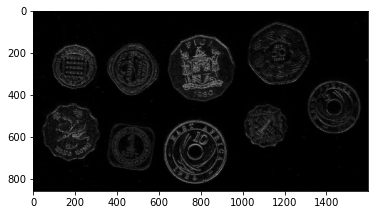

In [9]:
lap = cv2.Laplacian(image, cv2.CV_64F)
lap = np.uint8(np.absolute(lap))
plt.imshow(lap,'gray')

### Canny Edge Detector

The Canny edge detector is a multi-step process. It involves blurring the image to remove noise, computing Sobel 
gradient images in the x and y direction, suppressing edges, and finally a hysteresis thresholding stage that 
determines if a pixel is “edge-like” or not.

1. Gaussian blur to remove noise.
2. Compute the Sobel gradients along the x (G<sub>x</sub>) and y (G<sub>y</sub>) directions. 
![Gradient Calculation](images/sobel_x_andy.png)

The final gradient and angle are calculated by the formulae below
![Gradient Calculation](images/canny_sobel_formula.png)

3. After getting gradient magnitude and direction, a full scan of image is done to remove any unwanted pixels which may not constitute the edge. For this, at every pixel, the pixel is checked to see if it is a local maximum in its neighborhood in the direction of gradient.

4. Finally, we check which of the edges are *really* edges and which are not. For this, we need two threshold values; minVal and maxVal. Any edges with intensity gradient more than maxVal are sure to be edges (so we keep them) and those below minVal are sure to be non-edges (and therefore discarded). Those that lie in-between these two thresholds are classified as edges or non-edges based on their connectivity. If they are connected to "sure-edge" pixels, they are considered to be part of edges. Otherwise, they are also discarded. See the image below:

![Gradient Calculation](images/canny_hysteresis.jpeg)
The edge A is above the maxVal, so considered as "sure-edge". Although edge C is below maxVal, it is connected to edge A, so that also considered as valid edge and we get that full curve. But edge B, although it is above minVal and is in same region as that of edge C, it is not connected to any "sure-edge", so that is discarded. So it is very important that we have to select minVal and maxVal accordingly to get the correct result.

This stage also removes small pixels noises on the assumption that edges are long lines.

OpenCV puts all the above in single function, cv2.Canny(). 

First argument is our input image. Second and third arguments are our minVal and maxVal respectively.

Optionally arguments are:

* Aperture_size - size of Sobel kernel used for find image gradients. By default it is 3. 
* L2gradient - specifies the equation for finding gradient magnitude. If it is True, it uses the equation mentioned above, which is more accurate, otherwise it uses this function for Edge\_Gradient \: (G) = |G_x| + |G_y|. By default, it is False.

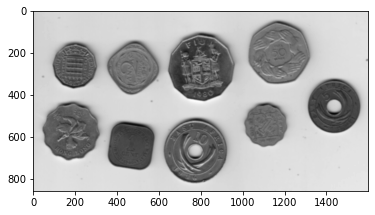

In [14]:
#Read in an image and blur it (this step isn't necessary, but leads to improved results)
image = cv2.imread("images/coin_collection.jpeg")
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (11, 11), 0)
interim_image = blurred
plt.imshow(blurred,'gray')

Further pre-processing the image, can help improve the results tremendously. e.g. using more blur, binarising using thesholds etc.

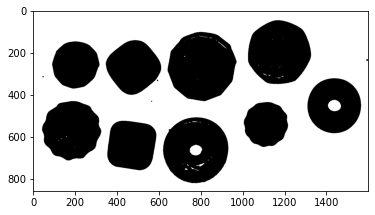

In [12]:
thresh = cv2.threshold(blurred, 180, 255, cv2.THRESH_BINARY)[1]
interim_image = thresh
plt.imshow(thresh,'gray')

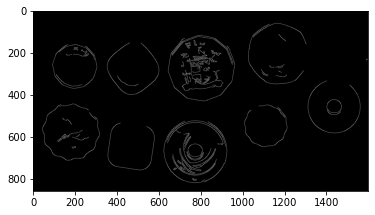

In [15]:
canny = cv2.Canny(interim_image, 50, 150)
plt.imshow(canny,'gray')

### Finding Contours
The first argument to cv2.findContours is our edged image. It’s important to note that this function is destructive to the image you pass in. If you intend using that image later on in your code, it’s best to make a copy of it, using the NumPy copy method.

The second argument is the type of contours we want. We use cv2.RETR_EXTERNAL to retrieve only the outermost contours (i.e., the contours that follow the outline of the coin). We can also pass in cv2.RETR_LIST to grab all contours. Other methods include hierarchical contours using cv2.RETR_COMP and cv2.RETR_TREE.

Our last argument is how we want to approximate the contour. We use cv2.CHAIN_APPROX_SIMPLE to compress horizontal, vertical, and diagonal segments into their end-points only. This saves both computation and memory.

We have 859 edges.
We have 13 contours.


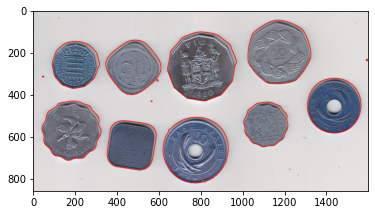

In [29]:
# contours, heirachy_list
(cnts, _) = cv2.findContours(canny.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
coins = image.copy()
cv2.drawContours(coins, cnts, -1, (255, 0, 0), 2)
print (f"We have {len(canny)} edges.")
print (f"We have {len(cnts)} contours.")
plt.imshow(coins,'gray')

Let's sort the contours by area

In [30]:
def get_contour_areas(cnts):
    all_areas= []
    for cnt in cnts:
        area= cv2.contourArea(cnt)
        all_areas.append(area)
    return all_areas

print ("Contour Areas before Sorting", get_contour_areas(cnts))
sorted_contours= sorted(cnts, key=cv2.contourArea, reverse= True)
print ("Contour Areas after Sorting", get_contour_areas(sorted_contours))

Contour Areas before Sorting [46222.0, 76962.5, 35039.5, 60490.5, 16.5, 35.5, 53102.0, 29.0, 2.0, 39108.0, 48655.0, 83270.5, 71767.5]
Contour Areas after Sorting [83270.5, 76962.5, 71767.5, 60490.5, 53102.0, 48655.0, 46222.0, 39108.0, 35039.5, 35.5, 29.0, 16.5, 2.0]


#### Post Processing
You can add a bounding box around each contour by using the bounding rect function. 

Let's do so for the 9 largest contours.

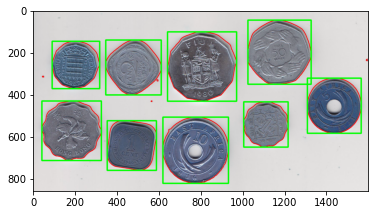

In [31]:
for cnt in sorted_contours[0:9]:
    x,y,w,h = cv2.boundingRect(cnt)
    cv2.rectangle(coins,(x,y),(x+w,y+h),(0,255,0),5)

plt.imshow(coins,'gray')

You can then use the bounding box to crop out each segment.

Alternatively, you can use moments locate the center of the contour, and do some processing based on that.


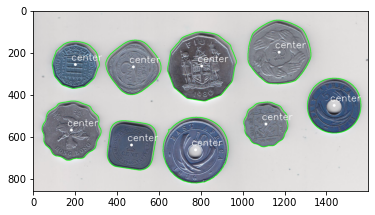

In [32]:
coins = image.copy()
# loop over the contours
for c in sorted_contours[0:9]:
	# compute the center of the contour
	M = cv2.moments(c)
	cX = int(M["m10"] / M["m00"])
	cY = int(M["m01"] / M["m00"])
	# draw the contour and center of the shape on the image
	cv2.drawContours(coins, [c], -1, (0, 255, 0), 2)
	cv2.circle(coins, (cX, cY), 7, (255, 255, 255), -1)
	cv2.putText(coins, "center", (cX - 20, cY - 20),
		cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 2)
	# show the image
	plt.imshow(coins,'gray')

There's [a ton of other things](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_contours/py_table_of_contents_contours/py_table_of_contents_contours.html) you can do with Contours.

**References for the above section**
1. https://docs.opencv.org/master/da/d22/tutorial_py_canny.html
2. https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html
3. https://docs.opencv.org/3.4/d5/db5/tutorial_laplace_operator.html


## Other Techniques Usable for Segmentation

### KMeans
#### Input parameters
samples : It should be of np.float32 data type, and each feature should be put in a single column.

nclusters(K) : Number of clusters required at end

criteria : It is the iteration termination criteria. When this criteria is satisfied, algorithm iteration stops.
This should be a tuple of 3 parameters. They are 

`( type, max_iter, epsilon )`:
1. type of termination criteria. It has 3 flags as below:
* cv.TERM_CRITERIA_EPS - stop the algorithm iteration if specified accuracy, epsilon, is reached.
* cv.TERM_CRITERIA_MAX_ITER - stop the algorithm after the specified number of iterations, max_iter.
* cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER - stop the iteration when any of the above condition is met.

2. max_iter - An integer specifying maximum number of iterations.
3. epsilon - Required accuracy

attempts : Flag to specify the number of times the algorithm is executed using different initial labellings. The algorithm returns the labels that yield the best compactness. This compactness is returned as output.

flags : This flag is used to specify how initial centers are taken. Normally two flags are used for this : cv.KMEANS_PP_CENTERS and cv.KMEANS_RANDOM_CENTERS.

#### Output parameters
compactness : It is the sum of squared distance from each point to their corresponding centers.

labels : This is the label array to that shows to which cluster each element belongs '0', '1'...

centers : This is the array of the centers of clusters.


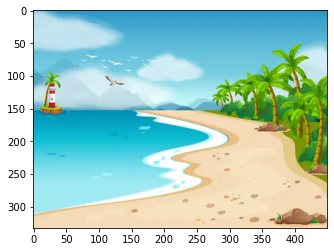

In [33]:
#Read Image and Convert to RGB
image_bgr = cv2.imread("images/cartoon_beach.webp")
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

# Reshape the image into a 2D array of pixels and 3 color values (RGB)
plt.imshow(image_rgb)
pixel_vals = image_rgb.reshape((-1,3))
 
# Convert to float type
pixel_vals = np.float32(pixel_vals)

"""This defines the criteria for the algorithm to stop running.
Either 100 iterations are run or the epsilon (which is the required accuracy)
becomes 85% and the algorithm stops."""
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

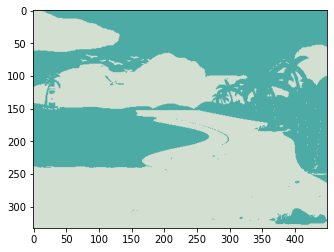

In [34]:
#Perform k-means clustering with number of clusters defined as 2
#Random centres are initially chosen
k = 2
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image_rgb.shape))
plt.imshow(segmented_image)

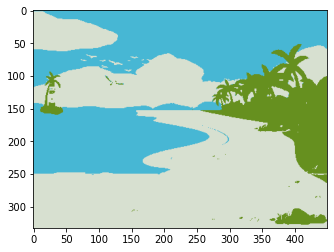

In [35]:
#Perform k-means clustering with number of clusters defined as 3
#Random centres are initially chosen
k = 3
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image_rgb.shape))
plt.imshow(segmented_image)

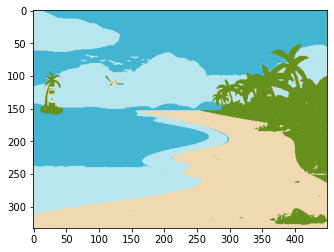

In [36]:
#Perform k-means clustering with number of clusters defined as 4
#Random centres are initially chosen
k = 4
retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
 
# convert data into 8-bit values
centers = np.uint8(centers)
segmented_data = centers[labels.flatten()]
 
# reshape data into the original image dimensions
segmented_image = segmented_data.reshape((image_rgb.shape))
plt.imshow(segmented_image)

### Masking
We've covered masking before. 

Only new thing is the inRange function. We use this to only allow values within a certain range (of RGB or HSV) instead of just specifying one intensity value like we do in grayscale.

The result is a binarised image with matching values as white, and the rest as black.

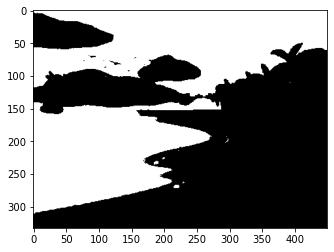

In [37]:
image_hsv = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2HSV)
light_blue = (90, 70, 50)
dark_blue = (128, 255, 255)
# You can use the following values for green
# light_green = (40, 40, 40)
# dark_greek = (70, 255, 255)
mask = cv2.inRange(image_hsv, light_blue, dark_blue)
plt.imshow(mask, 'gray')

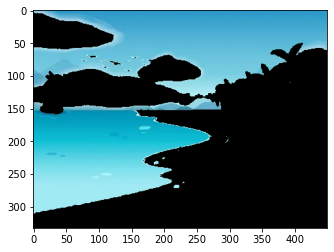

In [38]:
result = cv2.bitwise_and(image_rgb, image_rgb, mask=mask)
plt.imshow(result)